# Decision Tree Model

Best Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training Accuracy: 1.0000
Test Accuracy: 1.0000

Classification Report on Test Data:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        61
         1.0       1.00      1.00      1.00        99

    accuracy                           1.00       160
   macro avg       1.00      1.00      1.00       160
weighted avg       1.00      1.00      1.00       160


Confusion Matrix:
[[61  0]
 [ 0 99]]


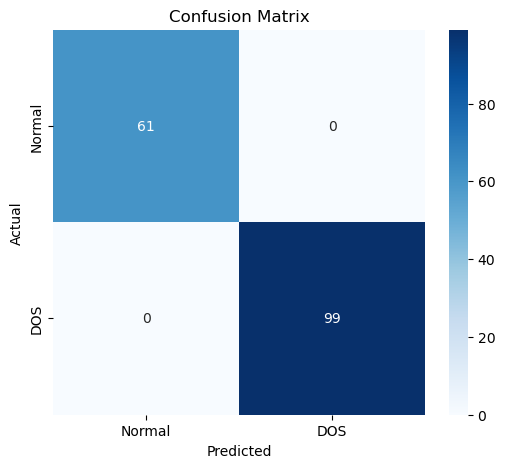

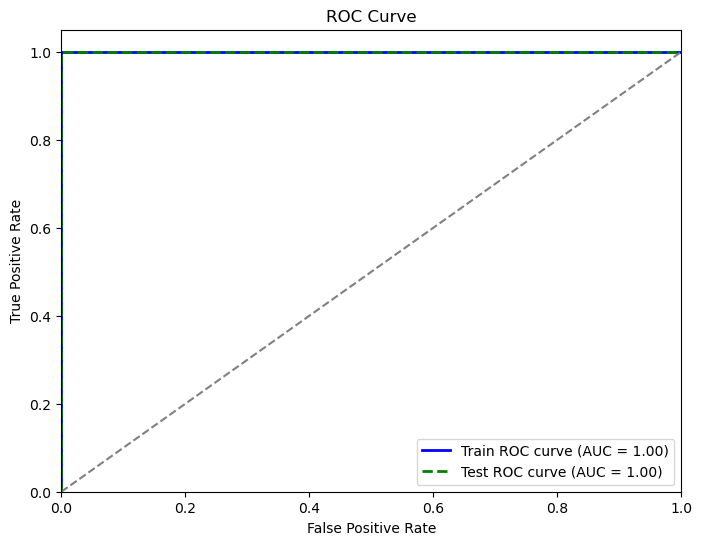

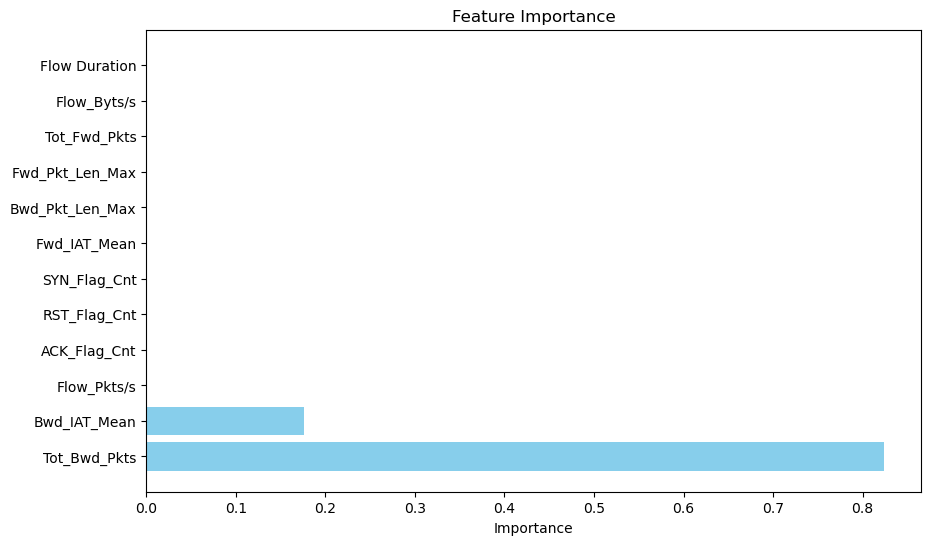

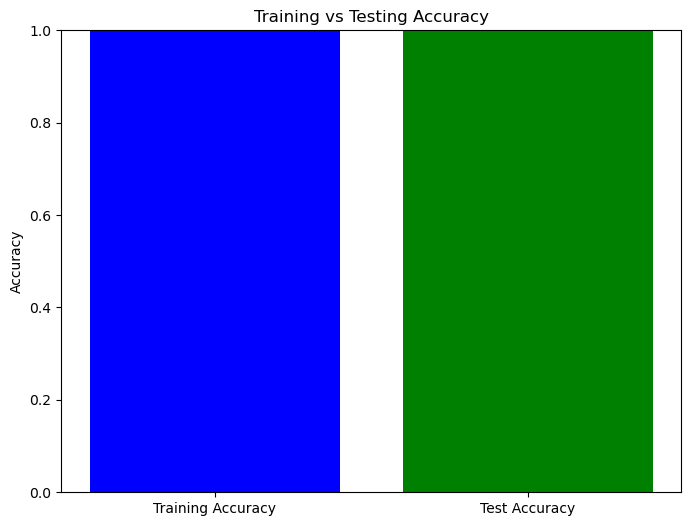


Predictions for the Test Dataset (without labels):
         Row Predicted_Label  Probability_Normal  Probability_DOS
0          1          Normal                 1.0              0.0
1          2          Normal                 1.0              0.0
2          3          Normal                 1.0              0.0
3          4          Normal                 1.0              0.0
4          5          Normal                 1.0              0.0
...      ...             ...                 ...              ...
32082  32083          Normal                 1.0              0.0
32083  32084          Normal                 1.0              0.0
32084  32085          Normal                 1.0              0.0
32085  32086          Normal                 1.0              0.0
32086  32087          Normal                 1.0              0.0

[32087 rows x 4 columns]


In [3]:
#Decision Tree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score, roc_curve, auc

# Load the dataset
df = pd.read_csv('updated_dataset.csv')

# Define the feature columns and the label column
feature_columns = [
    'Flow Duration', 'Flow_Byts/s', 'Tot_Fwd_Pkts', 'Tot_Bwd_Pkts', 
    'Fwd_Pkt_Len_Max', 'Bwd_Pkt_Len_Max', 'Fwd_IAT_Mean', 'Bwd_IAT_Mean',
    'SYN_Flag_Cnt', 'RST_Flag_Cnt', 'ACK_Flag_Cnt', 'Flow_Pkts/s'
]

label_column = 'Label'

# Drop irrelevant or non-numeric columns
df = df.drop(columns=['Time', 'Source', 'Destination', 'Protocol', 'Length', 'Info'], errors='ignore')

# Convert features to numeric
df[feature_columns] = df[feature_columns].apply(pd.to_numeric, errors='coerce')

# Map string labels to numeric values
label_mapping = {'Normal': 0, 'DOS': 1}
df[label_column] = df[label_column].map(label_mapping)

# Check for unmapped labels
if df[label_column].isna().sum() > 0:
    print("Unmapped labels found. Check your dataset!")
    raise ValueError("Unmapped labels detected.")

# Extract features (X) and labels (y)
X = df[feature_columns].values
y = df[label_column].values.astype(np.float32)

# Handle NaN and Infinite values in features
X[np.isnan(X)] = np.nanmean(X)  # Replace NaN with column mean
X[np.isinf(X)] = 0  # Replace Infinite values with 0

# Normalize the features using Min-Max scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define the parameter grid for Grid Search
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Decision Tree Classifier
classifier = DecisionTreeClassifier(random_state=42)

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model
best_classifier = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

# Make predictions on training and testing data
y_train_pred = best_classifier.predict(X_train)
y_test_pred = best_classifier.predict(X_test)

# Evaluate the model
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print the results
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Detailed evaluation on test data
print("\nClassification Report on Test Data:")
print(classification_report(y_test, y_test_pred))

# Confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

# Visualization of Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=['Normal', 'DOS'], yticklabels=['Normal', 'DOS'])
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr_train, tpr_train, _ = roc_curve(y_train, best_classifier.predict_proba(X_train)[:, 1])
fpr_test, tpr_test, _ = roc_curve(y_test, best_classifier.predict_proba(X_test)[:, 1])
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, linestyle='-', label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='green', lw=2, linestyle='--', label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


# Feature Importance
importances = best_classifier.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.barh(range(len(feature_columns)), importances[indices], align="center", color='skyblue')
plt.yticks(range(len(feature_columns)), np.array(feature_columns)[indices])
plt.xlabel("Importance")
plt.show()

# Plot the training and testing accuracy
accuracies = [train_accuracy, test_accuracy]
labels = ['Training Accuracy', 'Test Accuracy']

plt.figure(figsize=(8, 6))
plt.bar(labels, accuracies, color=['blue', 'green'])
plt.title('Training vs Testing Accuracy')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.show()

# Load the test dataset
test_df = pd.read_csv('newdata2.csv')

# Drop irrelevant or non-numeric columns
test_df = test_df.drop(columns=['Time', 'Source', 'Destination', 'Protocol', 'Length', 'Info'], errors='ignore')

# Ensure numeric conversion and match feature columns
test_df = test_df[feature_columns].apply(pd.to_numeric, errors='coerce')

# Handle missing or infinite values
for column in feature_columns:
    test_df[column].fillna(np.nanmean(X[:, feature_columns.index(column)]), inplace=True)
test_df.replace([np.inf, -np.inf], 0, inplace=True)

# Convert to NumPy array and scale
X_test_array = test_df.values  # Convert to NumPy array
X_test_scaled = scaler.transform(X_test_array)  # Use the same scaler

# Make predictions on the test data
test_predictions = best_classifier.predict(X_test_scaled)
test_predictions_proba = best_classifier.predict_proba(X_test_scaled)

# Reverse label mapping
reverse_label_mapping = {0: 'Normal', 1: 'DOS'}

# Create a DataFrame for predictions
predictions_df = pd.DataFrame({
    'Row': range(1, len(test_predictions) + 1),
    'Predicted_Label': [reverse_label_mapping[pred] for pred in test_predictions],
    'Probability_Normal': test_predictions_proba[:, 0],
    'Probability_DOS': test_predictions_proba[:, 1]
})

# Display the predictions
print("\nPredictions for the Test Dataset (without labels):")
print(predictions_df)

# Save predictions to a CSV file for reference
predictions_df.to_csv('test_predictions_new_dd.csv', index=False)


# KNN Model

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Training Accuracy: 1.0000
Test Accuracy: 0.9313

Classification Report on Test Data:
              precision    recall  f1-score   support

         0.0       0.95      0.87      0.91        61
         1.0       0.92      0.97      0.95        99

    accuracy                           0.93       160
   macro avg       0.93      0.92      0.93       160
weighted avg       0.93      0.93      0.93       160


Confusion Matrix:
[[53  8]
 [ 3 96]]


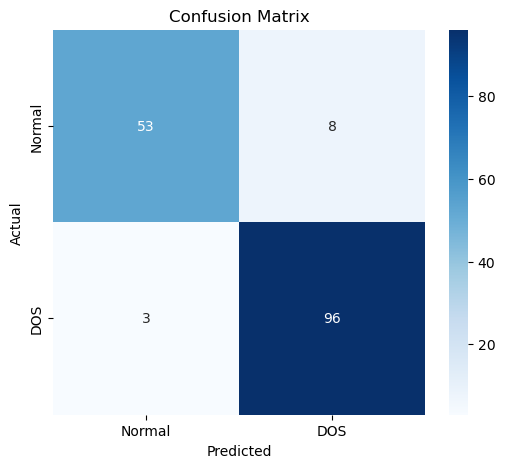

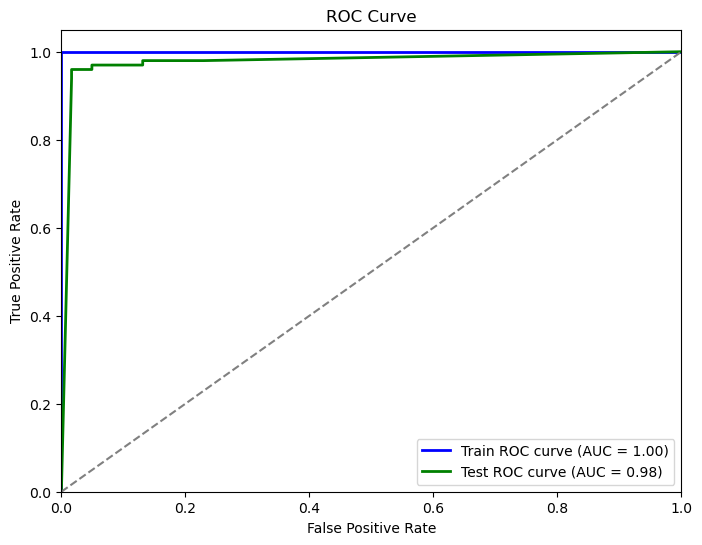


Predictions for the Test Dataset (without labels):
         Row Predicted_Label  Probability_Normal  Probability_DOS
0          1          Normal            1.000000         0.000000
1          2          Normal            1.000000         0.000000
2          3          Normal            1.000000         0.000000
3          4          Normal            1.000000         0.000000
4          5          Normal            1.000000         0.000000
...      ...             ...                 ...              ...
32082  32083             DOS            0.000000         1.000000
32083  32084             DOS            0.000000         1.000000
32084  32085          Normal            0.666706         0.333294
32085  32086             DOS            0.000000         1.000000
32086  32087             DOS            0.000000         1.000000

[32087 rows x 4 columns]


In [3]:
# KNN
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# Load the dataset
df = pd.read_csv('updated_dataset.csv')

# Define the feature columns and the label column
feature_columns = [
    'Flow Duration', 'Flow_Byts/s', 'Tot_Fwd_Pkts', 'Tot_Bwd_Pkts', 
    'Fwd_Pkt_Len_Max', 'Bwd_Pkt_Len_Max', 'Fwd_IAT_Mean', 'Bwd_IAT_Mean',
    'SYN_Flag_Cnt', 'RST_Flag_Cnt', 'ACK_Flag_Cnt', 'Flow_Pkts/s'
]
label_column = 'Label'

# Drop irrelevant or non-numeric columns
df = df.drop(columns=['Time', 'Source', 'Destination', 'Protocol', 'Length', 'Info'], errors='ignore')

# Convert features to numeric
df[feature_columns] = df[feature_columns].apply(pd.to_numeric, errors='coerce')

# Map string labels to numeric values
label_mapping = {'Normal': 0, 'DOS': 1}
df[label_column] = df[label_column].map(label_mapping)

# Check for unmapped labels
if df[label_column].isna().sum() > 0:
    print("Unmapped labels found. Check your dataset!")
    raise ValueError("Unmapped labels detected.")

# Extract features (X) and labels (y)
X = df[feature_columns].values
y = df[label_column].values.astype(np.float32)

# Handle NaN and Infinite values in features
X[np.isnan(X)] = np.nanmean(X)  # Replace NaN with column mean
X[np.isinf(X)] = 0  # Replace Infinite values with 0

# Normalize the features using Min-Max scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define the parameter grid for Grid Search
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Initialize the KNN Classifier
classifier = KNeighborsClassifier()

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model
best_classifier = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

# Make predictions on training and testing data
y_train_pred = best_classifier.predict(X_train)
y_test_pred = best_classifier.predict(X_test)

# Evaluate the model
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print the results
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Detailed evaluation on test data
print("\nClassification Report on Test Data:")
print(classification_report(y_test, y_test_pred))

# Confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

# Visualization of Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=['Normal', 'DOS'], yticklabels=['Normal', 'DOS'])
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
y_train_proba = best_classifier.predict_proba(X_train)[:, 1]
y_test_proba = best_classifier.predict_proba(X_test)[:, 1]
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='green', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Load the test dataset
test_df = pd.read_csv('newdata2.csv')

# Drop irrelevant or non-numeric columns
test_df = test_df.drop(columns=['Time', 'Source', 'Destination', 'Protocol', 'Length', 'Info'], errors='ignore')

# Ensure numeric conversion and match feature columns
test_df = test_df[feature_columns].apply(pd.to_numeric, errors='coerce')

# Handle missing or infinite values
for column in feature_columns:
    test_df[column].fillna(np.nanmean(X[:, feature_columns.index(column)]), inplace=True)
test_df.replace([np.inf, -np.inf], 0, inplace=True)

# Convert to NumPy array and scale
X_test_array = test_df.values
X_test_scaled = scaler.transform(X_test_array)

# Make predictions on the test data
test_predictions = best_classifier.predict(X_test_scaled)
test_predictions_proba = best_classifier.predict_proba(X_test_scaled)

# Reverse label mapping
reverse_label_mapping = {0: 'Normal', 1: 'DOS'}

# Create a DataFrame for predictions
predictions_df = pd.DataFrame({
    'Row': range(1, len(test_predictions) + 1),
    'Predicted_Label': [reverse_label_mapping[pred] for pred in test_predictions],
    'Probability_Normal': test_predictions_proba[:, 0],
    'Probability_DOS': test_predictions_proba[:, 1]
})

# Display the predictions
print("\nPredictions for the Test Dataset (without labels):")
print(predictions_df)

# Save predictions to a CSV file for reference
predictions_df.to_csv('test_predictions_new_knn.csv', index=False)


# Random Forest

Best Parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Training Accuracy: 1.0000
Test Accuracy: 1.0000

Classification Report on Test Data:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        61
         1.0       1.00      1.00      1.00        99

    accuracy                           1.00       160
   macro avg       1.00      1.00      1.00       160
weighted avg       1.00      1.00      1.00       160


Confusion Matrix:
[[61  0]
 [ 0 99]]


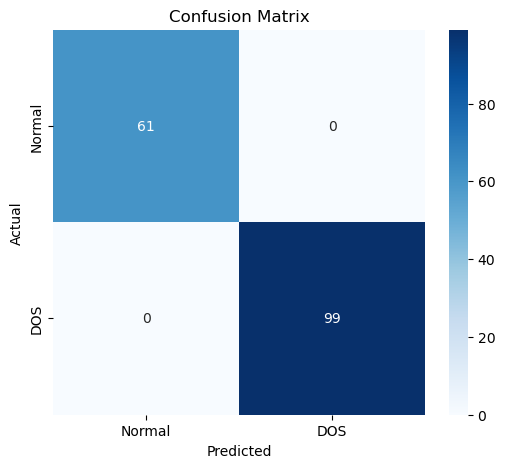

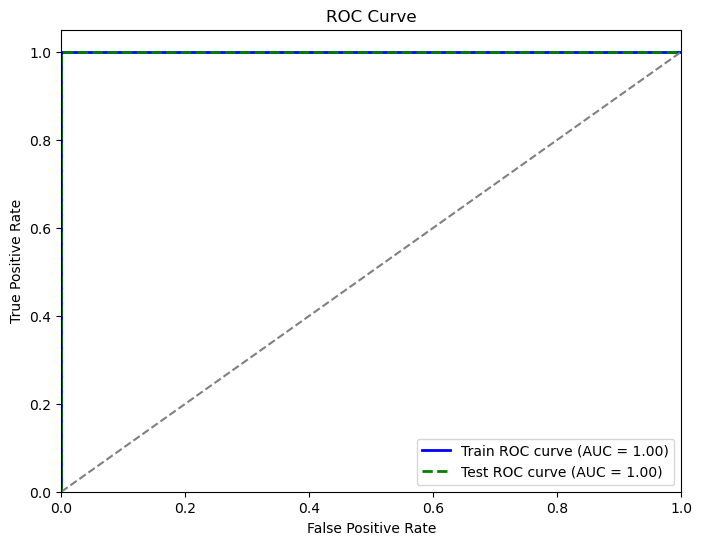


Predictions for the Test Dataset (without labels):
         Row Predicted_Label  Probability_Normal  Probability_DOS
0          1          Normal               1.000            0.000
1          2          Normal               1.000            0.000
2          3          Normal               1.000            0.000
3          4          Normal               1.000            0.000
4          5          Normal               1.000            0.000
...      ...             ...                 ...              ...
32082  32083          Normal               0.630            0.370
32083  32084          Normal               0.645            0.355
32084  32085          Normal               0.730            0.270
32085  32086          Normal               0.680            0.320
32086  32087          Normal               0.650            0.350

[32087 rows x 4 columns]


In [4]:
#Random Forest 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# Load the dataset
df = pd.read_csv('updated_dataset.csv')

# Define the feature columns and the label column
feature_columns = [
    'Flow Duration', 'Flow_Byts/s', 'Tot_Fwd_Pkts', 'Tot_Bwd_Pkts', 
    'Fwd_Pkt_Len_Max', 'Bwd_Pkt_Len_Max', 'Fwd_IAT_Mean', 'Bwd_IAT_Mean',
    'SYN_Flag_Cnt', 'RST_Flag_Cnt', 'ACK_Flag_Cnt', 'Flow_Pkts/s'
]
label_column = 'Label'

# Drop irrelevant or non-numeric columns
df = df.drop(columns=['Time', 'Source', 'Destination', 'Protocol', 'Length', 'Info'], errors='ignore')

# Convert features to numeric
df[feature_columns] = df[feature_columns].apply(pd.to_numeric, errors='coerce')

# Map string labels to numeric values
label_mapping = {'Normal': 0, 'DOS': 1}
df[label_column] = df[label_column].map(label_mapping)

# Check for unmapped labels
if df[label_column].isna().sum() > 0:
    print("Unmapped labels found. Check your dataset!")
    raise ValueError("Unmapped labels detected.")

# Extract features (X) and labels (y)
X = df[feature_columns].values
y = df[label_column].values.astype(np.float32)

# Handle NaN and Infinite values in features
X[np.isnan(X)] = np.nanmean(X)  # Replace NaN with column mean
X[np.isinf(X)] = 0  # Replace Infinite values with 0

# Normalize the features using Min-Max scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define the parameter grid for Grid Search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the Random Forest Classifier
classifier = RandomForestClassifier(random_state=42)

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model
best_classifier = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

# Make predictions on training and testing data
y_train_pred = best_classifier.predict(X_train)
y_test_pred = best_classifier.predict(X_test)

# Evaluate the model
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print the results
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Detailed evaluation on test data
print("\nClassification Report on Test Data:")
print(classification_report(y_test, y_test_pred))

# Confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

# Visualization of Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=['Normal', 'DOS'], yticklabels=['Normal', 'DOS'])
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr_train, tpr_train, _ = roc_curve(y_train, best_classifier.predict_proba(X_train)[:, 1])
fpr_test, tpr_test, _ = roc_curve(y_test, best_classifier.predict_proba(X_test)[:, 1])
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, linestyle='-', label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='green', lw=2, linestyle='--', label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


# Load the test dataset
test_df = pd.read_csv('newdata2.csv')

# Drop irrelevant or non-numeric columns
test_df = test_df.drop(columns=['Time', 'Source', 'Destination', 'Protocol', 'Length', 'Info'], errors='ignore')

# Ensure numeric conversion and match feature columns
test_df = test_df[feature_columns].apply(pd.to_numeric, errors='coerce')

# Handle missing or infinite values
for column in feature_columns:
    test_df[column].fillna(np.nanmean(X[:, feature_columns.index(column)]), inplace=True)
test_df.replace([np.inf, -np.inf], 0, inplace=True)

# Convert to NumPy array and scale
X_test_array = test_df.values
X_test_scaled = scaler.transform(X_test_array)

# Make predictions on the test data
test_predictions = best_classifier.predict(X_test_scaled)
test_predictions_proba = best_classifier.predict_proba(X_test_scaled)

# Reverse label mapping
reverse_label_mapping = {0: 'Normal', 1: 'DOS'}

# Create a DataFrame for predictions
predictions_df = pd.DataFrame({
    'Row': range(1, len(test_predictions) + 1),
    'Predicted_Label': [reverse_label_mapping[pred] for pred in test_predictions],
    'Probability_Normal': test_predictions_proba[:, 0],
    'Probability_DOS': test_predictions_proba[:, 1]
})

# Display the predictions
print("\nPredictions for the Test Dataset (without labels):")
print(predictions_df)

# Save predictions to a CSV file for reference
predictions_df.to_csv('test_predictions_new_rf.csv', index=False)

# LSTM Model

Epoch 1/20


C:\Users\palgunitr\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5236 - loss: 0.6903 - val_accuracy: 0.6187 - val_loss: 0.6611
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5712 - loss: 0.6603 - val_accuracy: 0.6187 - val_loss: 0.6335
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6143 - loss: 0.6301 - val_accuracy: 0.6187 - val_loss: 0.6122
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5712 - loss: 0.6335 - val_accuracy: 0.6187 - val_loss: 0.5989
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5908 - loss: 0.6139 - val_accuracy: 0.6187 - val_loss: 0.5838
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5941 - loss: 0.5944 - val_accuracy: 0.6250 - val_loss: 0.5684
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6242 - loss: 0.5773 - val_accuracy: 0.6687 - val_loss: 0.5510
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6733 - loss: 0.5474 - val_accuracy: 0.7500 - val_loss: 0.5323
Ep

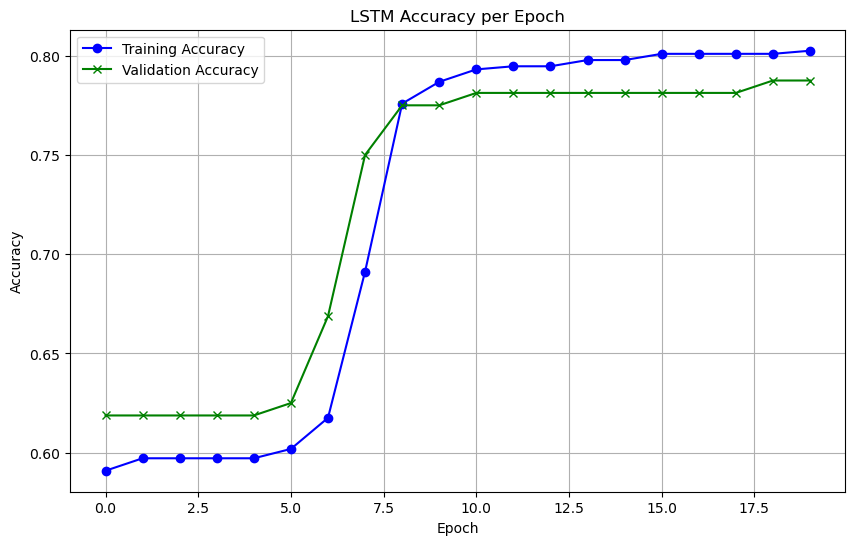

Test Accuracy: 0.7875
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  

Classification Report:
              precision    recall  f1-score   support

         0.0       0.71      0.75      0.73        61
         1.0       0.84      0.81      0.82        99

    accuracy                           0.79       160
   macro avg       0.77      0.78      0.78       160
weighted avg       0.79      0.79      0.79       160


Confusion Matrix:
[[46 15]
 [19 80]]


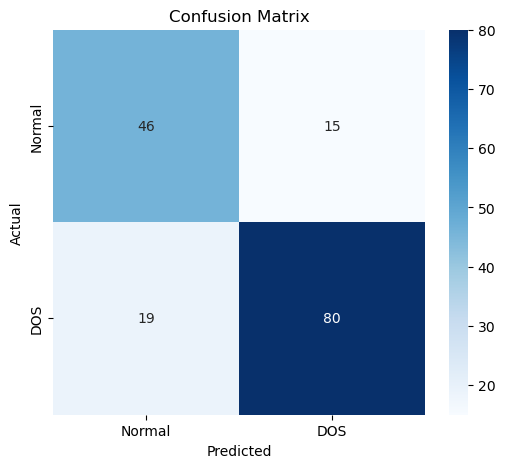

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step


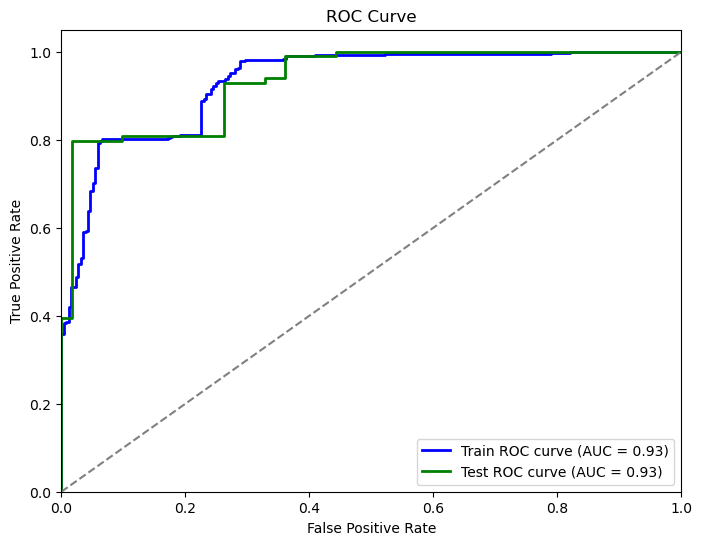

1003/1003 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Predictions for the Test Dataset (without labels):
         Row Predicted_Label  Probability_Normal  Probability_DOS
0          1          Normal            0.550400         0.449600
1          2          Normal            0.520235         0.479765
2          3          Normal            0.539388         0.460612
3          4          Normal            0.529304         0.470696
4          5          Normal            0.551929         0.448071
...      ...             ...                 ...              ...
32082  32083          Normal            0.781448         0.218552
32083  32084          Normal            0.781397         0.218603
32084  32085          Normal            0.759521         0.240479
32085  32086          Normal            0.777535         0.222465
32086  32087          Normal            0.781563         0.218437

[32087 rows x 4 columns]


In [5]:
#LSTM
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# Load the dataset
df = pd.read_csv('updated_dataset.csv')

# Define the feature columns and the label column
feature_columns = [
    'Flow Duration', 'Flow_Byts/s', 'Tot_Fwd_Pkts', 'Tot_Bwd_Pkts', 
    'Fwd_Pkt_Len_Max', 'Bwd_Pkt_Len_Max', 'Fwd_IAT_Mean', 'Bwd_IAT_Mean',
    'SYN_Flag_Cnt', 'RST_Flag_Cnt', 'ACK_Flag_Cnt', 'Flow_Pkts/s'
]

label_column = 'Label'

# Drop irrelevant or non-numeric columns
df = df.drop(columns=['Time', 'Source', 'Destination', 'Protocol', 'Length', 'Info'], errors='ignore')

# Convert features to numeric
df[feature_columns] = df[feature_columns].apply(pd.to_numeric, errors='coerce')

# Map string labels to numeric values
label_mapping = {'Normal': 0, 'DOS': 1}
df[label_column] = df[label_column].map(label_mapping)

# Check for unmapped labels
if df[label_column].isna().sum() > 0:
    print("Unmapped labels found. Check your dataset!")
    raise ValueError("Unmapped labels detected.")

# Extract features (X) and labels (y)
X = df[feature_columns].values
y = df[label_column].values.astype(np.float32)

# Handle NaN and Infinite values in features
X[np.isnan(X)] = np.nanmean(X)  # Replace NaN with column mean
X[np.isinf(X)] = 0  # Replace Infinite values with 0

# Normalize the features using Min-Max scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape the input to be compatible with LSTM
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model and capture the training history
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# Accuracy per epoch
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the training and validation accuracy per epoch
plt.figure(figsize=(10, 6))
plt.plot(train_accuracy, label='Training Accuracy', color='blue', linestyle='-', marker='o')
plt.plot(val_accuracy, label='Validation Accuracy', color='green', linestyle='-', marker='x')
plt.title('LSTM Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predict on test data
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Visualization of Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=['Normal', 'DOS'], yticklabels=['Normal', 'DOS'])
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr_train, tpr_train, _ = roc_curve(y_train, model.predict(X_train)[:, 0])
fpr_test, tpr_test, _ = roc_curve(y_test, model.predict(X_test)[:, 0])
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='green', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Load the test dataset
test_df = pd.read_csv('newdata2.csv')

# Preprocess the test dataset
test_df = test_df.drop(columns=['Time', 'Source', 'Destination', 'Protocol', 'Length', 'Info'], errors='ignore')
test_df = test_df[feature_columns].apply(pd.to_numeric, errors='coerce')

# Handle missing or infinite values
for column in feature_columns:
    test_df[column].fillna(np.nanmean(X[:, feature_columns.index(column)]), inplace=True)
test_df.replace([np.inf, -np.inf], 0, inplace=True)

# Convert to NumPy array, scale, and reshape for LSTM
X_test_array = test_df.values
X_test_scaled = scaler.transform(X_test_array)
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

# Make predictions on the test dataset
test_predictions = model.predict(X_test_lstm)
test_predictions_classes = np.argmax(test_predictions, axis=1)

# Reverse label mapping
reverse_label_mapping = {0: 'Normal', 1: 'DOS'}

predictions_df = pd.DataFrame({
    'Row': range(1, len(test_predictions) + 1),
    'Predicted_Label': [reverse_label_mapping[pred] for pred in test_predictions_classes],
    'Probability_Normal': test_predictions[:, 0],
    'Probability_DOS': 1 - test_predictions[:, 0]  # Compute the complement probability
})

# Display the predictions
print("\nPredictions for the Test Dataset (without labels):")
print(predictions_df)

# Save predictions to a CSV file for reference
predictions_df.to_csv('test_predictions_new_lstm.csv', index=False)


# Neural Network Model

Epoch 1/20


C:\Users\palgunitr\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4775 - loss: 0.7018 - val_accuracy: 0.7375 - val_loss: 0.6289
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7679 - loss: 0.6092 - val_accuracy: 0.7688 - val_loss: 0.5613
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7588 - loss: 0.5558 - val_accuracy: 0.7688 - val_loss: 0.5085
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7828 - loss: 0.4915 - val_accuracy: 0.7750 - val_loss: 0.4675
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8104 - loss: 0.4361 - val_accuracy: 0.7812 - val_loss: 0.4426
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8010 - loss: 0.4313 - val_accuracy: 0.7812 - val_loss: 0.4222
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7824 - loss: 0.4405 - val_accuracy: 0.7812 - val_loss: 0.4032
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7955 - loss: 0.4123 - val_accuracy: 0.7812 - val_loss: 0.3836
Ep

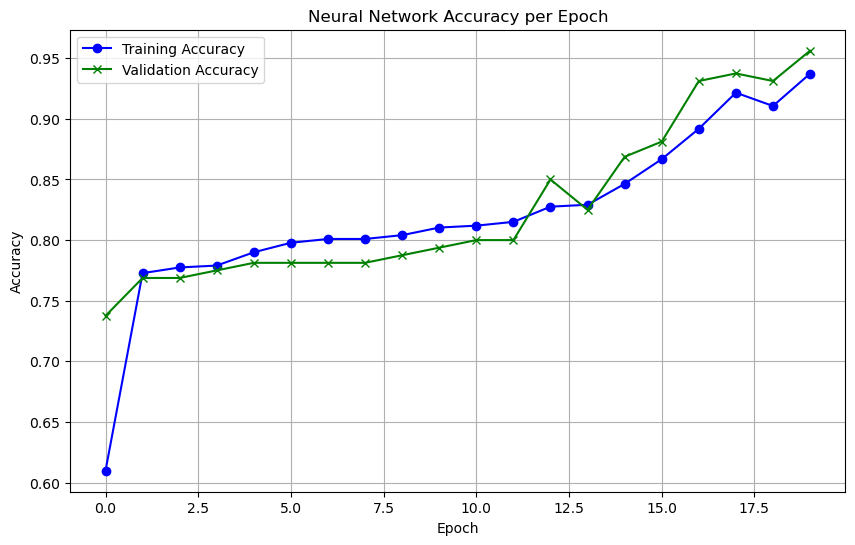

Test Accuracy: 0.9563
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.98      0.94        61
         1.0       0.99      0.94      0.96        99

    accuracy                           0.96       160
   macro avg       0.95      0.96      0.95       160
weighted avg       0.96      0.96      0.96       160


Confusion Matrix:
[[60  1]
 [ 6 93]]


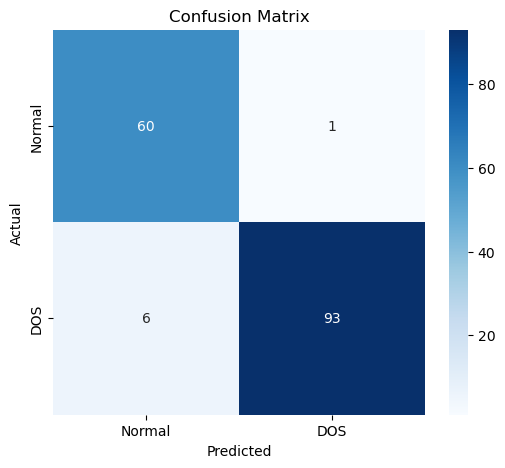

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


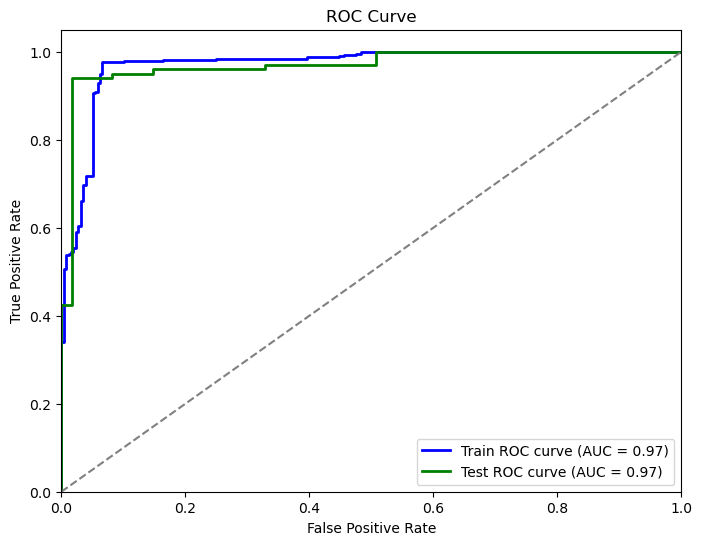

1003/1003 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Predictions for the Test Dataset (without labels):
         Row Predicted_Label  Probability_Normal  Probability_DOS
0          1          Normal            0.167719         0.832281
1          2          Normal            0.171750         0.828250
2          3          Normal            0.184883         0.815117
3          4          Normal            0.197963         0.802037
4          5          Normal            0.191035         0.808965
...      ...             ...                 ...              ...
32082  32083          Normal            0.904699         0.095301
32083  32084          Normal            0.904623         0.095377
32084  32085          Normal            0.212426         0.787574
32085  32086          Normal            0.898593         0.101407
32086  32087          Normal            0.903543         0.096457

[32087 rows x 4 columns]


In [6]:
#Neural network
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# Load the dataset
df = pd.read_csv('updated_dataset.csv')

# Define the feature columns and the label column
feature_columns = [
    'Flow Duration', 'Flow_Byts/s', 'Tot_Fwd_Pkts', 'Tot_Bwd_Pkts', 
    'Fwd_Pkt_Len_Max', 'Bwd_Pkt_Len_Max', 'Fwd_IAT_Mean', 'Bwd_IAT_Mean',
    'SYN_Flag_Cnt', 'RST_Flag_Cnt', 'ACK_Flag_Cnt', 'Flow_Pkts/s'
]

label_column = 'Label'

# Drop irrelevant or non-numeric columns
df = df.drop(columns=['Time', 'Source', 'Destination', 'Protocol', 'Length', 'Info'], errors='ignore')

# Convert features to numeric
df[feature_columns] = df[feature_columns].apply(pd.to_numeric, errors='coerce')

# Map string labels to numeric values
label_mapping = {'Normal': 0, 'DOS': 1}
df[label_column] = df[label_column].map(label_mapping)

# Check for unmapped labels
if df[label_column].isna().sum() > 0:
    print("Unmapped labels found. Check your dataset!")
    raise ValueError("Unmapped labels detected.")

# Extract features (X) and labels (y)
X = df[feature_columns].values
y = df[label_column].values.astype(np.float32)

# Handle NaN and Infinite values in features
X[np.isnan(X)] = np.nanmean(X)  # Replace NaN with column mean
X[np.isinf(X)] = 0  # Replace Infinite values with 0

# Normalize the features using Min-Max scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build a fully connected neural network model (Dense Layers)
model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))  # First hidden layer
model.add(Dense(units=32, activation='relu'))  # Second hidden layer
model.add(Dense(units=1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model and capture the training history
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# Accuracy per epoch
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the training and validation accuracy per epoch
plt.figure(figsize=(10, 6))
plt.plot(train_accuracy, label='Training Accuracy', color='blue', linestyle='-', marker='o')
plt.plot(val_accuracy, label='Validation Accuracy', color='green', linestyle='-', marker='x')
plt.title('Neural Network Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predict on test data
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Visualization of Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=['Normal', 'DOS'], yticklabels=['Normal', 'DOS'])
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr_train, tpr_train, _ = roc_curve(y_train, model.predict(X_train)[:, 0])
fpr_test, tpr_test, _ = roc_curve(y_test, model.predict(X_test)[:, 0])
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='green', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Load the test dataset
test_df = pd.read_csv('newdata2.csv')

# Preprocess the test dataset
test_df = test_df.drop(columns=['Time', 'Source', 'Destination', 'Protocol', 'Length', 'Info'], errors='ignore')
test_df = test_df[feature_columns].apply(pd.to_numeric, errors='coerce')

# Handle missing or infinite values
for column in feature_columns:
    test_df[column].fillna(np.nanmean(X[:, feature_columns.index(column)]), inplace=True)
test_df.replace([np.inf, -np.inf], 0, inplace=True)

# Convert to NumPy array and scale
X_test_array = test_df.values
X_test_scaled = scaler.transform(X_test_array)

# Make predictions on the test dataset
test_predictions = model.predict(X_test_scaled)
test_predictions_classes = np.argmax(test_predictions, axis=1)

# Reverse label mapping
reverse_label_mapping = {0: 'Normal', 1: 'DOS'}

predictions_df = pd.DataFrame({
    'Row': range(1, len(test_predictions) + 1),
    'Predicted_Label': [reverse_label_mapping[pred] for pred in test_predictions_classes],
    'Probability_Normal': test_predictions[:, 0],
    'Probability_DOS': 1 - test_predictions[:, 0]  # Compute the complement probability
})


# Display the predictions
print("\nPredictions for the Test Dataset (without labels):")
print(predictions_df)

# Save predictions to a CSV file for reference
predictions_df.to_csv('test_predictions_new_nn.csv', index=False)


# Comparision of 5 models

C:\Users\palgunitr\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


C:\Users\palgunitr\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


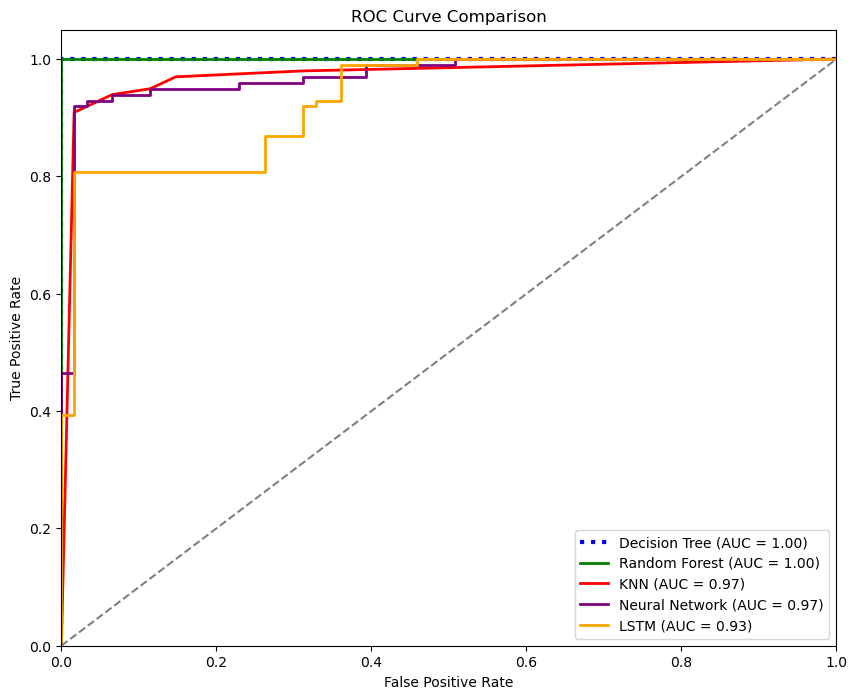

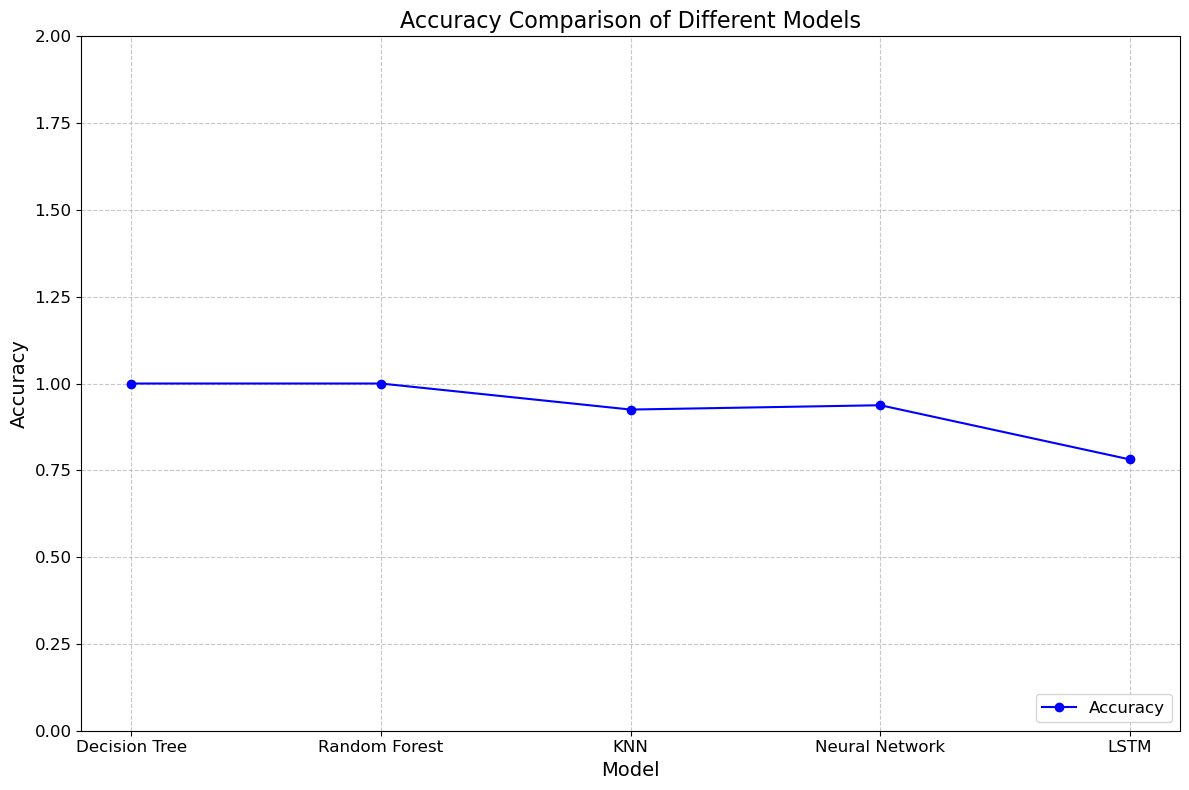

In [1]:
#comparision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from keras.layers import Dense, LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

# Load the dataset
df = pd.read_csv('updated_dataset.csv')

# Define the feature columns and the label column
feature_columns = [
    'Flow Duration', 'Flow_Byts/s', 'Tot_Fwd_Pkts', 'Tot_Bwd_Pkts', 
    'Fwd_Pkt_Len_Max', 'Bwd_Pkt_Len_Max', 'Fwd_IAT_Mean', 'Bwd_IAT_Mean',
    'SYN_Flag_Cnt', 'RST_Flag_Cnt', 'ACK_Flag_Cnt', 'Flow_Pkts/s'
]

label_column = 'Label'

# Drop irrelevant or non-numeric columns
df = df.drop(columns=['Time', 'Source', 'Destination', 'Protocol', 'Length', 'Info'], errors='ignore')

# Convert features to numeric
df[feature_columns] = df[feature_columns].apply(pd.to_numeric, errors='coerce')

# Map string labels to numeric values
label_mapping = {'Normal': 0, 'DOS': 1}
df[label_column] = df[label_column].map(label_mapping)

# Check for unmapped labels
if df[label_column].isna().sum() > 0:
    print("Unmapped labels found. Check your dataset!")
    raise ValueError("Unmapped labels detected.")

# Extract features (X) and labels (y)
X = df[feature_columns].values
y = df[label_column].values.astype(np.float32)

# Handle NaN and Infinite values in features
X[np.isnan(X)] = np.nanmean(X)  # Replace NaN with column mean
X[np.isinf(X)] = 0  # Replace Infinite values with 0

# Normalize the features using Min-Max scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize models

# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# K-Nearest Neighbors (KNN)
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

# Neural Network (Fully Connected)
nn_model = Sequential()
nn_model.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))  # First hidden layer
nn_model.add(Dense(units=32, activation='relu'))  # Second hidden layer
nn_model.add(Dense(units=1, activation='sigmoid'))  # Output layer for binary classification

nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
nn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=0)

y_pred_nn = (nn_model.predict(X_test) > 0.5).astype(int)

# LSTM Model
X_train_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dense(units=1, activation='sigmoid'))
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=32, validation_data=(X_test_lstm, y_test), verbose=0)

y_pred_lstm = (lstm_model.predict(X_test_lstm) > 0.5).astype(int)

# Calculate ROC curves and AUC for all models
fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_model.predict_proba(X_test)[:, 1])
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
fpr_knn, tpr_knn, _ = roc_curve(y_test, knn_model.predict_proba(X_test)[:, 1])
fpr_nn, tpr_nn, _ = roc_curve(y_test, nn_model.predict(X_test)[:, 0])
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, lstm_model.predict(X_test_lstm)[:, 0])

roc_auc_dt = auc(fpr_dt, tpr_dt)
roc_auc_rf = auc(fpr_rf, tpr_rf)
roc_auc_knn = auc(fpr_knn, tpr_knn)
roc_auc_nn = auc(fpr_nn, tpr_nn)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_dt, tpr_dt, color='blue', linestyle='dotted', lw=3, label=f'Decision Tree (AUC = {roc_auc_dt:.2f})')
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_knn, tpr_knn, color='red', lw=2, label=f'KNN (AUC = {roc_auc_knn:.2f})')
plt.plot(fpr_nn, tpr_nn, color='purple', lw=2, label=f'Neural Network (AUC = {roc_auc_nn:.2f})')
plt.plot(fpr_lstm, tpr_lstm, color='orange', lw=2, label=f'LSTM (AUC = {roc_auc_lstm:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

accuracy_dt = accuracy_score(y_test, y_pred_dt)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
accuracy_nn = accuracy_score(y_test, y_pred_nn)
accuracy_lstm = accuracy_score(y_test, y_pred_lstm)

models = ['Decision Tree', 'Random Forest', 'KNN', 'Neural Network', 'LSTM']
accuracies = [accuracy_dt, accuracy_rf, accuracy_knn, accuracy_nn, accuracy_lstm]

plt.figure(figsize=(12, 8))  # Increased figure size
plt.plot(models, accuracies, marker='o', linestyle='-', color='b', label='Accuracy')
plt.xlabel('Model', fontsize=14)  # Increased font size for clarity
plt.ylabel('Accuracy', fontsize=14)
plt.title('Accuracy Comparison of Different Models', fontsize=16)
plt.ylim([0, 2])  # Adjust y-axis scale to [0, 2]
plt.xticks(fontsize=12)  # Adjust x-axis tick size
plt.yticks(fontsize=12)  # Adjust y-axis tick size
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='lower right', fontsize=12)  # Adjust legend font size
plt.tight_layout()  # Automatically adjust layout for better spacing
plt.show()






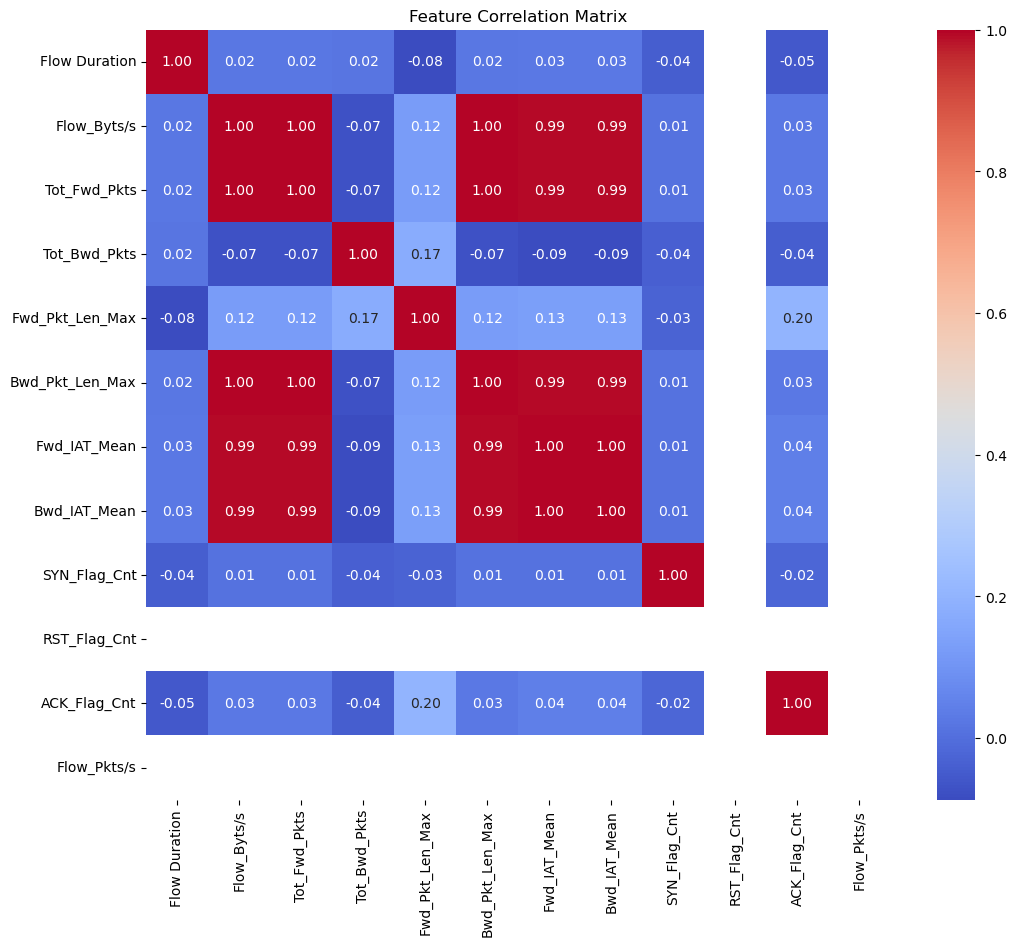

In [7]:
# Correlation heatmap for feature relationships
def plot_correlation_matrix(df, feature_columns):
    plt.figure(figsize=(12, 10))
    corr_matrix = df[feature_columns].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Feature Correlation Matrix')
    plt.show()

# Call the function
plot_correlation_matrix(df, feature_columns)


C:\Users\palgunitr\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


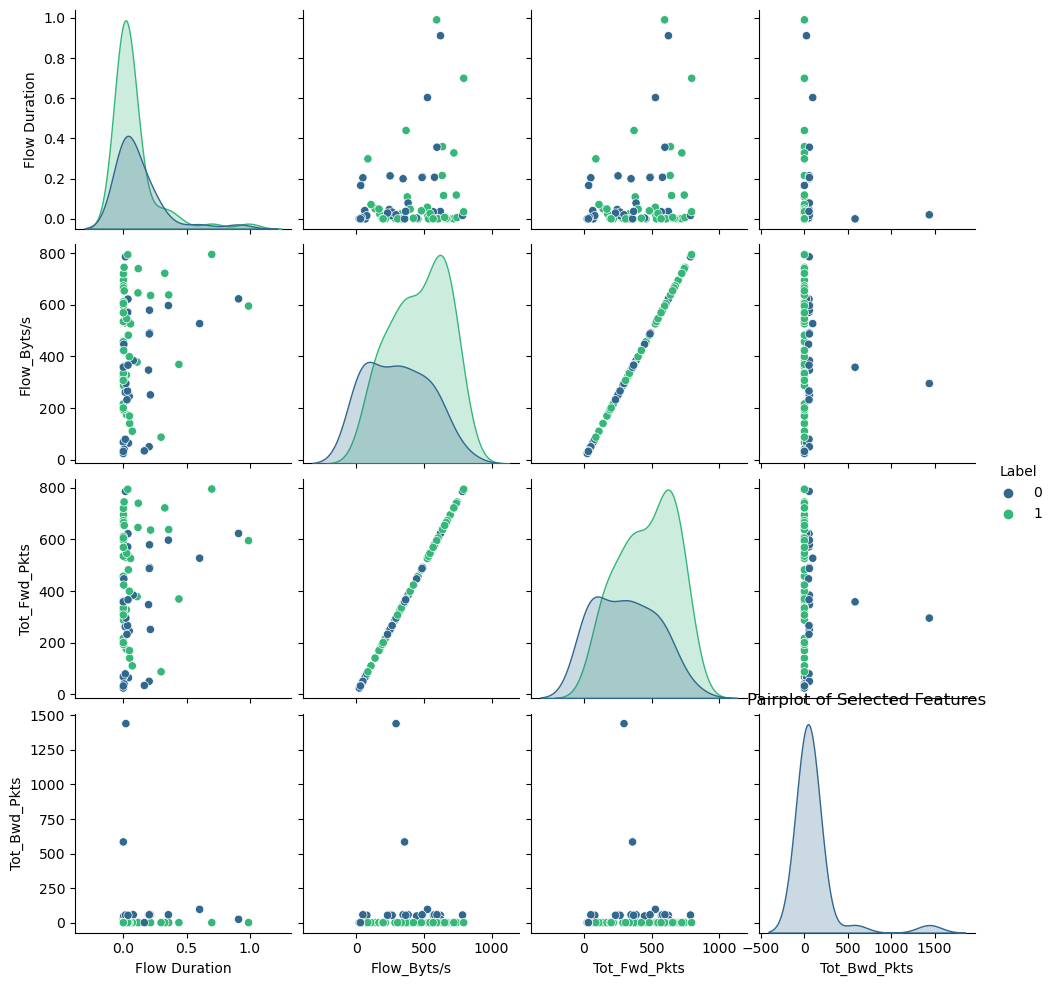

In [8]:
# Pairplot for feature analysis based on attack type
def plot_pairplot(df, feature_columns, label_column):
    sample_df = df.sample(frac=0.1, random_state=42)  # Use a smaller sample for performance
    sns.pairplot(sample_df, vars=feature_columns[:4], hue=label_column, palette='viridis')
    plt.title('Pairplot of Selected Features')
    plt.show()

# Call the function
plot_pairplot(df, feature_columns, label_column)


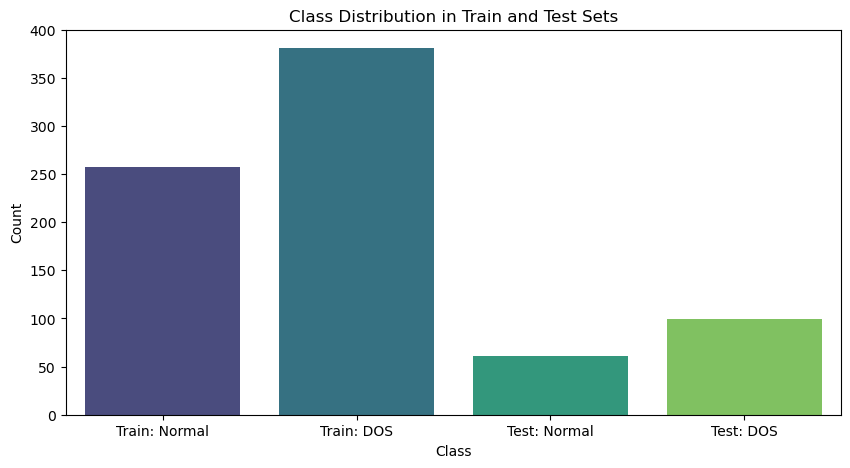

In [9]:
# Visualize class distribution
def plot_class_distribution(y_train, y_test):
    plt.figure(figsize=(10, 5))
    sns.barplot(
        x=['Train: Normal', 'Train: DOS', 'Test: Normal', 'Test: DOS'],
        y=[sum(y_train == 0), sum(y_train == 1), sum(y_test == 0), sum(y_test == 1)],
        palette='viridis'
    )
    plt.title('Class Distribution in Train and Test Sets')
    plt.ylabel('Count')
    plt.xlabel('Class')
    plt.show()

# Call the function
plot_class_distribution(y_train, y_test)


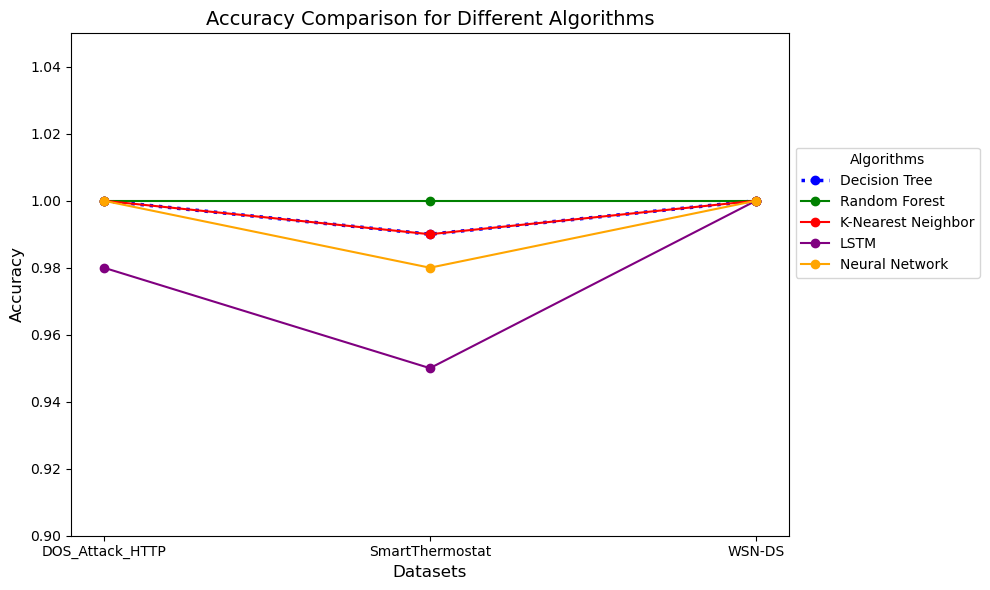

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Dataset names and corresponding accuracies for each algorithm
datasets = ["DOS_Attack_HTTP", "SmartThermostat", "WSN-DS"]
decision_tree_acc = [1.00, 0.99, 1.00]
random_forest_acc = [1.00, 1.00, 1.00]
knn_acc = [1.00, 0.99, 1.00]
lstm_acc = [0.98, 0.95, 1.00]
neural_network_acc = [1.00, 0.98, 1.00]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot lines for each algorithm
plt.plot(datasets, decision_tree_acc, marker='o', linestyle='dotted', color="blue", linewidth=2.5, label="Decision Tree")  # Thicker dotted blue line
plt.plot(datasets, random_forest_acc, marker='o', linestyle='-', color="green", label="Random Forest")
plt.plot(datasets, knn_acc, marker='o', linestyle='-', color="red", label="K-Nearest Neighbor")
plt.plot(datasets, lstm_acc, marker='o', linestyle='-', color="purple", label="LSTM")
plt.plot(datasets, neural_network_acc, marker='o', linestyle='-', color="orange", label="Neural Network")

# Add labels, title, and legend
plt.xlabel("Datasets", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Accuracy Comparison for Different Algorithms", fontsize=14)
plt.ylim(0.9, 1.05)
plt.legend(loc="lower left", bbox_to_anchor=(1, 0.5), title="Algorithms")

# Display the plot
plt.tight_layout()
plt.show()


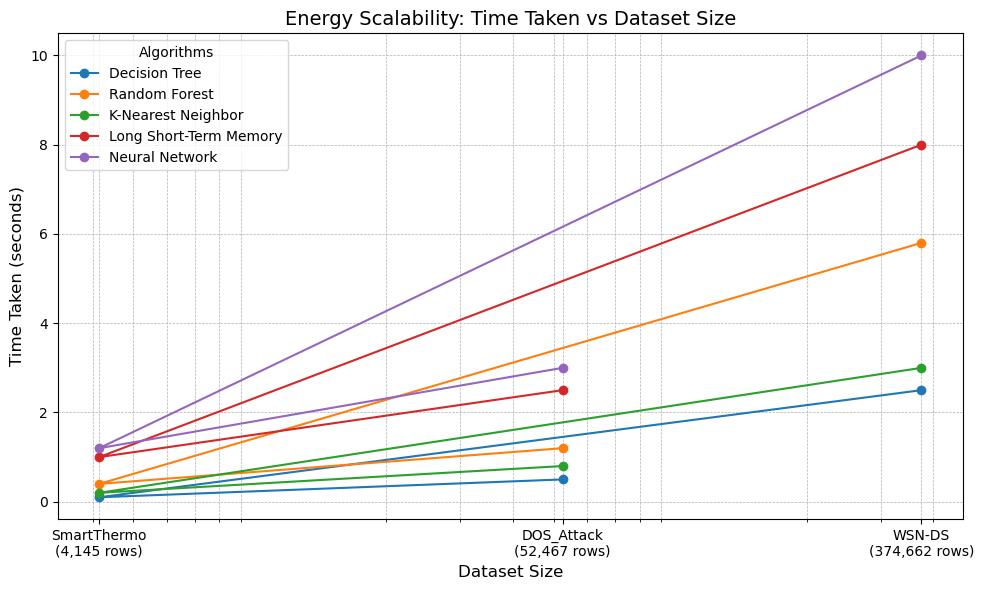

In [11]:
import matplotlib.pyplot as plt

# Dataset sizes and algorithms' time (hypothetical values)
dataset_sizes = [52467, 4145, 374662]
dataset_labels = ["DOS_Attack\n(52,467 rows)", "SmartThermo\n(4,145 rows)", "WSN-DS\n(374,662 rows)"]
algorithms = {
    "Decision Tree": [0.5, 0.1, 2.5],
    "Random Forest": [1.2, 0.4, 5.8],
    "K-Nearest Neighbor": [0.8, 0.2, 3.0],
    "Long Short-Term Memory": [2.5, 1.0, 8.0],
    "Neural Network": [3.0, 1.2, 10.0],
}

# Plotting
plt.figure(figsize=(10, 6))
for algorithm, times in algorithms.items():
    plt.plot(dataset_sizes, times, marker='o', label=algorithm)

# Graph labels and legend
plt.title("Energy Scalability: Time Taken vs Dataset Size", fontsize=14)
plt.xlabel("Dataset Size", fontsize=12)
plt.ylabel("Time Taken (seconds)", fontsize=12)

# Use log scale for x-axis
plt.xscale("log")
plt.xticks(dataset_sizes, dataset_labels)  # Custom x-axis labels

# Add grid, legend, and adjust layout
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend(title="Algorithms", fontsize=10)
plt.tight_layout()

# Display the graph
plt.show()


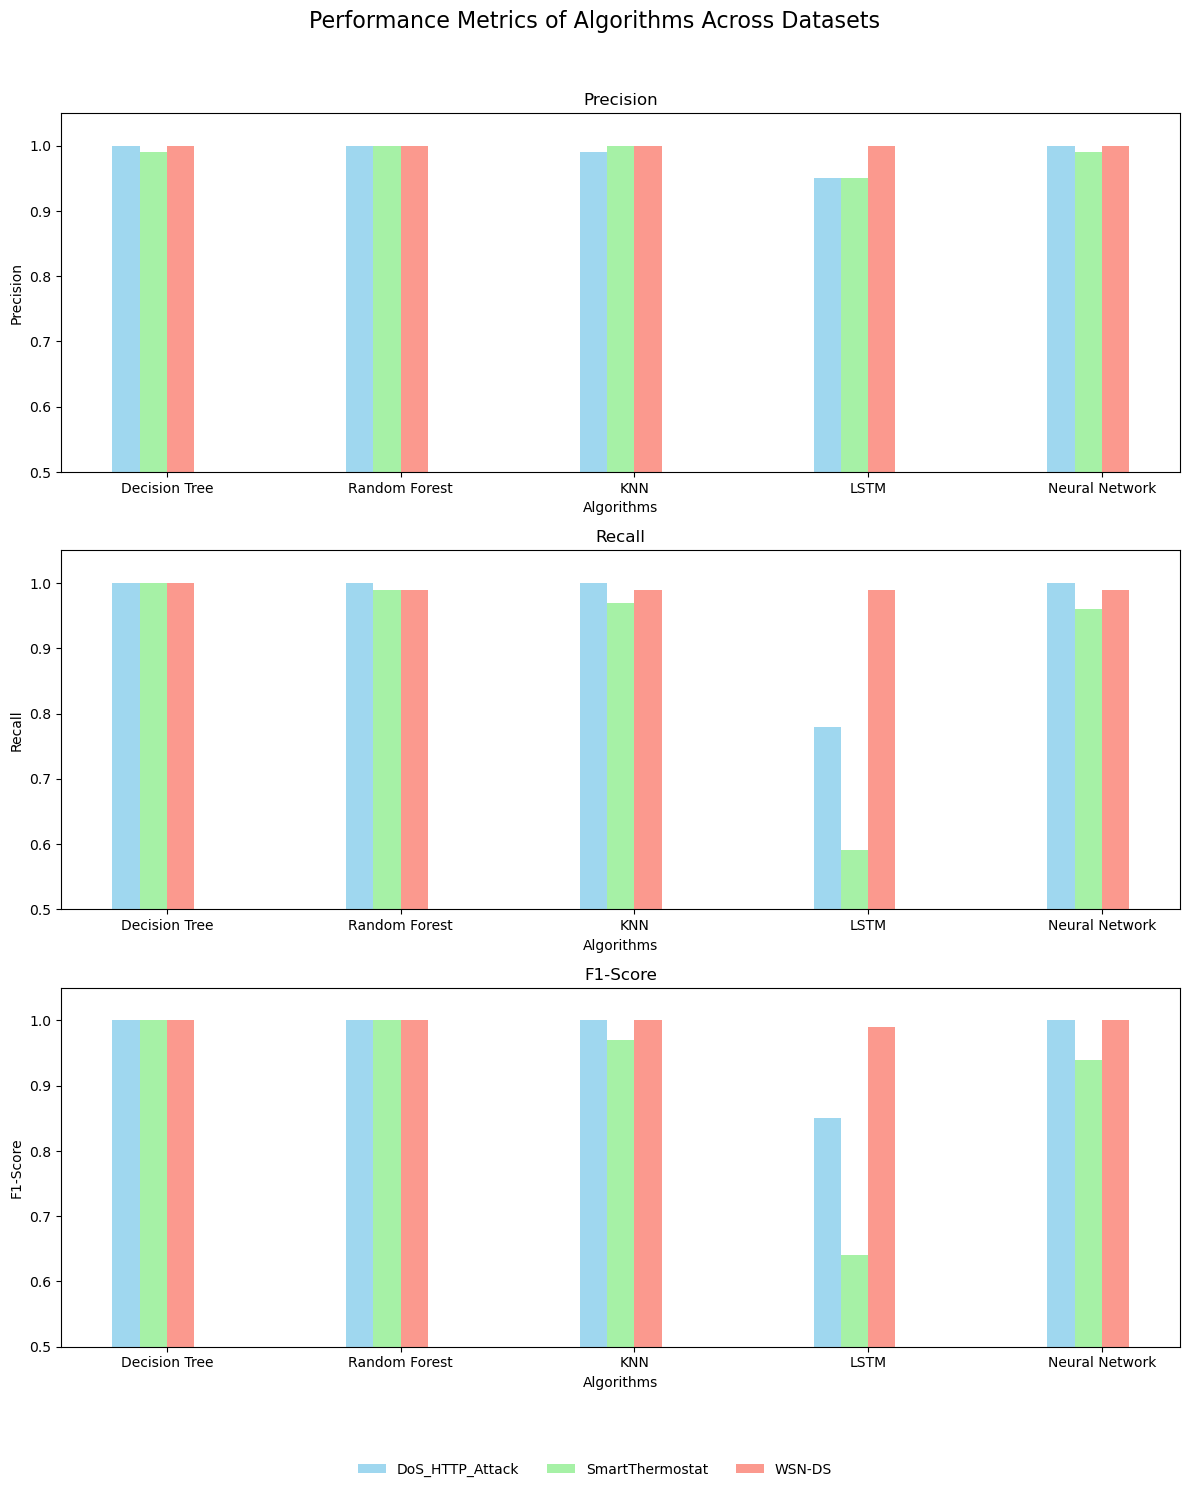

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the algorithms and datasets
algorithms = ["Decision Tree", "Random Forest", "KNN", "LSTM", "Neural Network"]
datasets_updated = ["DoS_HTTP_Attack", "SmartThermostat", "WSN-DS"]

# Performance metrics for each algorithm per dataset
# Dataset 1
precision_dataset1 = [1.00, 1.00, 0.99, 0.95, 1.00]
recall_dataset1 = [1.00, 1.00, 1.00, 0.78, 1.00]
f1_score_dataset1 = [1.00, 1.00, 1.00, 0.85, 1.00]

# Dataset 2
precision_dataset2 = [0.99, 1.00, 1.00, 0.95, 0.99]
recall_dataset2 = [1.00, 0.99, 0.97, 0.59, 0.96]
f1_score_dataset2 = [1.00, 1.00, 0.97, 0.64, 0.94]

# Dataset 3
precision_dataset3 = [1.00, 1.00, 1.00, 1.00, 1.00]
recall_dataset3 = [1.00, 0.99, 0.99, 0.99, 0.99]
f1_score_dataset3 = [1.00, 1.00, 1.00, 0.99, 1.00]

# Grouped data
precision = [precision_dataset1, precision_dataset2, precision_dataset3]
recall = [recall_dataset1, recall_dataset2, recall_dataset3]
f1_score = [f1_score_dataset1, f1_score_dataset2, f1_score_dataset3]

# Plot settings
metrics = ["Precision", "Recall", "F1-Score"]
metric_data = [precision, recall, f1_score]
colors = ['skyblue', 'lightgreen', 'salmon']

# Plotting
x = np.arange(len(algorithms))
width = 0.35

fig, axs = plt.subplots(3, 1, figsize=(12, 15))
fig.suptitle('Performance Metrics of Algorithms Across Datasets', fontsize=16)

for i, metric in enumerate(metrics):
    for j, dataset in enumerate(datasets_updated):
        axs[i].bar(
            x + j * width / len(datasets_updated) - width/2,
            metric_data[i][j],
            width/len(datasets_updated),
            label=f"{dataset}",
            alpha=0.8,
            color=colors[j]
        )

    axs[i].set_title(metric)
    axs[i].set_xlabel("Algorithms")
    axs[i].set_ylabel(metric)
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(algorithms)
    axs[i].set_ylim(0.5, 1.05)

# Place a single legend outside the plots
fig.legend(
    datasets_updated, 
    loc="upper center", 
    bbox_to_anchor=(0.5, 0.02),  # Position the legend below the plots
    ncol=len(datasets_updated),  # Arrange legend items in a single row
    frameon=False
)

plt.tight_layout(rect=[0, 0.05, 1, 0.96])  # Adjust layout to accommodate the legend
plt.show()
